## Text Classification With RNN 



In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf 

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline
The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info= True, as_supervised= True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMON63N/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMON63N/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMON63N/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Dataset of text, label pairs

In [6]:
for example, label in train_dataset.take(1):
  print('text:', example.numpy())
  print('label:', label.numpy())

text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label: 0


In [7]:
# Shuffle 
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I just read a review defending this film because it had a low budget, now my take on things.<br /><br />The CGI monsters was reasonable well animated but was implemented in the worst possible way. The fight scenes weren't even fights it was just one shot of an actor then one shot of monster with very interaction at all. When the monster did interact it looked like it was done in paintshop pro. In my opinion if you have a low budget you should use models and puppets. They may not look as fancy but at least they interact, just look at Peter Jacksons early films.<br /><br />As for the acting Beowulf did an descent job but the rest of the cast were either not trying or they forgot where they where.<br /><br />The script seemed confused to me. One minute they would be talking as if it were a modern day setting the next you get drama club Shakespeare speech. I'm not say it should be all 'ye' and 'that it be' but you need to find a cohesive balance so the lines sound like they come

## Create the text encoder 

The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the experimental.preprocessing.TextVectorization layer. This layer has many capabilities.

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = VOCAB_SIZE
)

encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Now we can encode our text into indices, with padded zeroes


In [13]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  41, 321, ...,   0,   0,   0],
       [ 74, 142,   1, ...,   0,   0,   0],
       [ 10,  96,  61, ...,   0,   0,   0]])

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round- trip", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I just read a review defending this film because it had a low budget, now my take on things.<br /><br />The CGI monsters was reasonable well animated but was implemented in the worst possible way. The fight scenes weren't even fights it was just one shot of an actor then one shot of monster with very interaction at all. When the monster did interact it looked like it was done in paintshop pro. In my opinion if you have a low budget you should use models and puppets. They may not look as fancy but at least they interact, just look at Peter Jacksons early films.<br /><br />As for the acting Beowulf did an descent job but the rest of the cast were either not trying or they forgot where they where.<br /><br />The script seemed confused to me. One minute they would be talking as if it were a modern day setting the next you get drama club Shakespeare speech. I'm not say it should be all 'ye' and 'that it be' but you need to find a cohesive balance so the lines sound like they co

In [15]:
model = tf.keras.Sequential([
                             encoder,
                             tf.keras.layers.Embedding(
                                 input_dim = len(encoder.get_vocabulary()),
                                 output_dim = 64,
                                 mask_zero = True
                             ),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation = 'relu'),
                             tf.keras.layers.Dense(1)
])


In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:



In [17]:
# predict on a sample text without padding 
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

prediction = model.predict(np.array([sample_text]))
print(prediction[0])

[0.00758174]


In [19]:
# with padding 

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00758174]


In [20]:
# Compile the keras model 
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
# train 


history = model.fit(train_dataset, epochs = 10,
                    validation_data = test_dataset,
                    validation_steps = 30)

Epoch 1/10
391/391 [==============================] - 677s 2s/step - loss: 0.6475 - accuracy: 0.5571 - val_loss: 0.5064 - val_accuracy: 0.7750
Epoch 2/10
391/391 [==============================] - 665s 2s/step - loss: 0.4044 - accuracy: 0.8124 - val_loss: 0.3591 - val_accuracy: 0.8344
Epoch 3/10
391/391 [==============================] - 662s 2s/step - loss: 0.3389 - accuracy: 0.8506 - val_loss: 0.3512 - val_accuracy: 0.8604
Epoch 4/10
391/391 [==============================] - 662s 2s/step - loss: 0.3211 - accuracy: 0.8610 - val_loss: 0.3317 - val_accuracy: 0.8510
Epoch 5/10
391/391 [==============================] - 654s 2s/step - loss: 0.3136 - accuracy: 0.8651 - val_loss: 0.3305 - val_accuracy: 0.8464
Epoch 6/10
391/391 [==============================] - 658s 2s/step - loss: 0.3107 - accuracy: 0.8652 - val_loss: 0.3285 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 655s 2s/step - loss: 0.3040 - accuracy: 0.8693 - val_loss: 0.3212 - val_accuracy: 0.8583

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 140s 358ms/step - loss: 0.3212 - accuracy: 0.8599
Test Loss: 0.32119473814964294
Test Accuracy: 0.8598799705505371


(0.0, 0.6649209916591644)

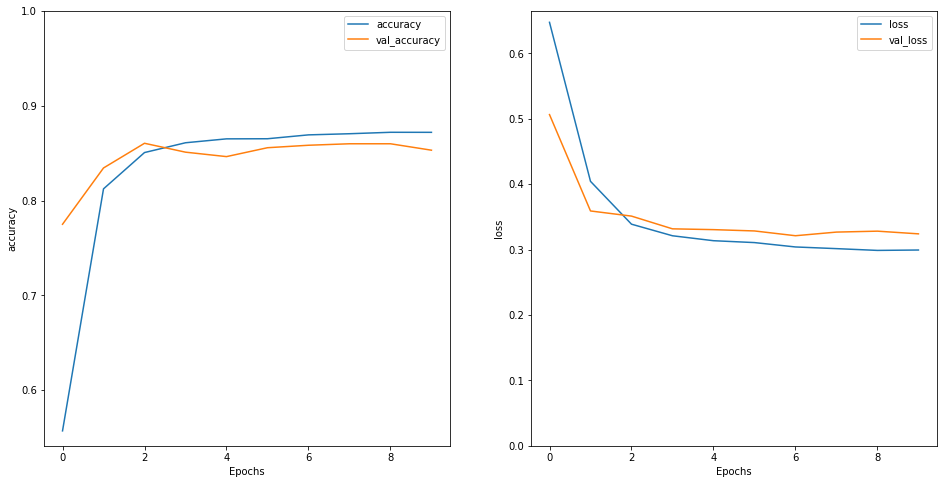

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [24]:
# prediction on a new sentence 

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers
Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

If False it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

If True the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape (batch_size, timesteps, output_features)).

In [25]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1241s 3s/step - loss: 0.6215 - accuracy: 0.5917 - val_loss: 0.4249 - val_accuracy: 0.8193
Epoch 2/10
391/391 [==============================] - 1217s 3s/step - loss: 0.3815 - accuracy: 0.8332 - val_loss: 0.3476 - val_accuracy: 0.8380
Epoch 3/10
391/391 [==============================] - 1206s 3s/step - loss: 0.3353 - accuracy: 0.8583 - val_loss: 0.3277 - val_accuracy: 0.8526
Epoch 4/10
391/391 [==============================] - 1208s 3s/step - loss: 0.3203 - accuracy: 0.8646 - val_loss: 0.3284 - val_accuracy: 0.8557
Epoch 5/10
219/391 [===============>..............] - ETA: 8:40 - loss: 0.3090 - accuracy: 0.8733

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')